## Read Drifter Data from EcoFOCI web

1986-2015 Quality Controlled Data is available from https://www.ecofoci.noaa.gov/drifters/efoci_drifterData.shtml

Formats and options change (as do headerlines and meta information) throughout the window of time available.  Usually, all files of a given year are well documented and similar.

In [49]:

import pandas as pd
import numpy as np

import datetime

In [46]:
data = {}
column_names=['latitude','longitude','year','doy','hhmm','drogue','battery','sst','satqual','ice']

#function to parse dates that are three column information
dateparse = lambda x: pd.datetime.strptime(x, '%Y %j %H%M')

for i in range(136859,136873,1):
    try:
        data.update({i:pd.read_csv('https://www.ecofoci.noaa.gov/drifters/data2015/'+str(i)+'_y2015_withTandIce.asc', 
                    dtype={'hhmm': str, 'year': str, 'doy': str},
                    header=29,
                    names=column_names,
                    delimiter='\s+',
                    parse_dates=[['year','doy','hhmm']],
                    date_parser=dateparse, 
                    index_col='year_doy_hhmm')})
    except:
        print("No data for {i}".format(i=i))

No data for 136871
No data for 136872


### Overview Plot using python-gmt

In [20]:
import gmt

In [21]:
fig = gmt.Figure()

fig.coast(region=[-175, -145, 65, 75], projection='B-160/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

In [85]:
for drifterid,ddata in data.items():
    ddata['dayofyear'] = ddata.index.dayofyear
    #dfmiss.dayofyear.loc[(df.dayofyear > 0) | (df.dayofyear < 366)] = np.nan
    # normalize data for colormap
    fig.plot(x=-1*ddata.longitude, y=ddata.latitude, color=256*ddata.sst, cmap='phase', style='c0.05c')

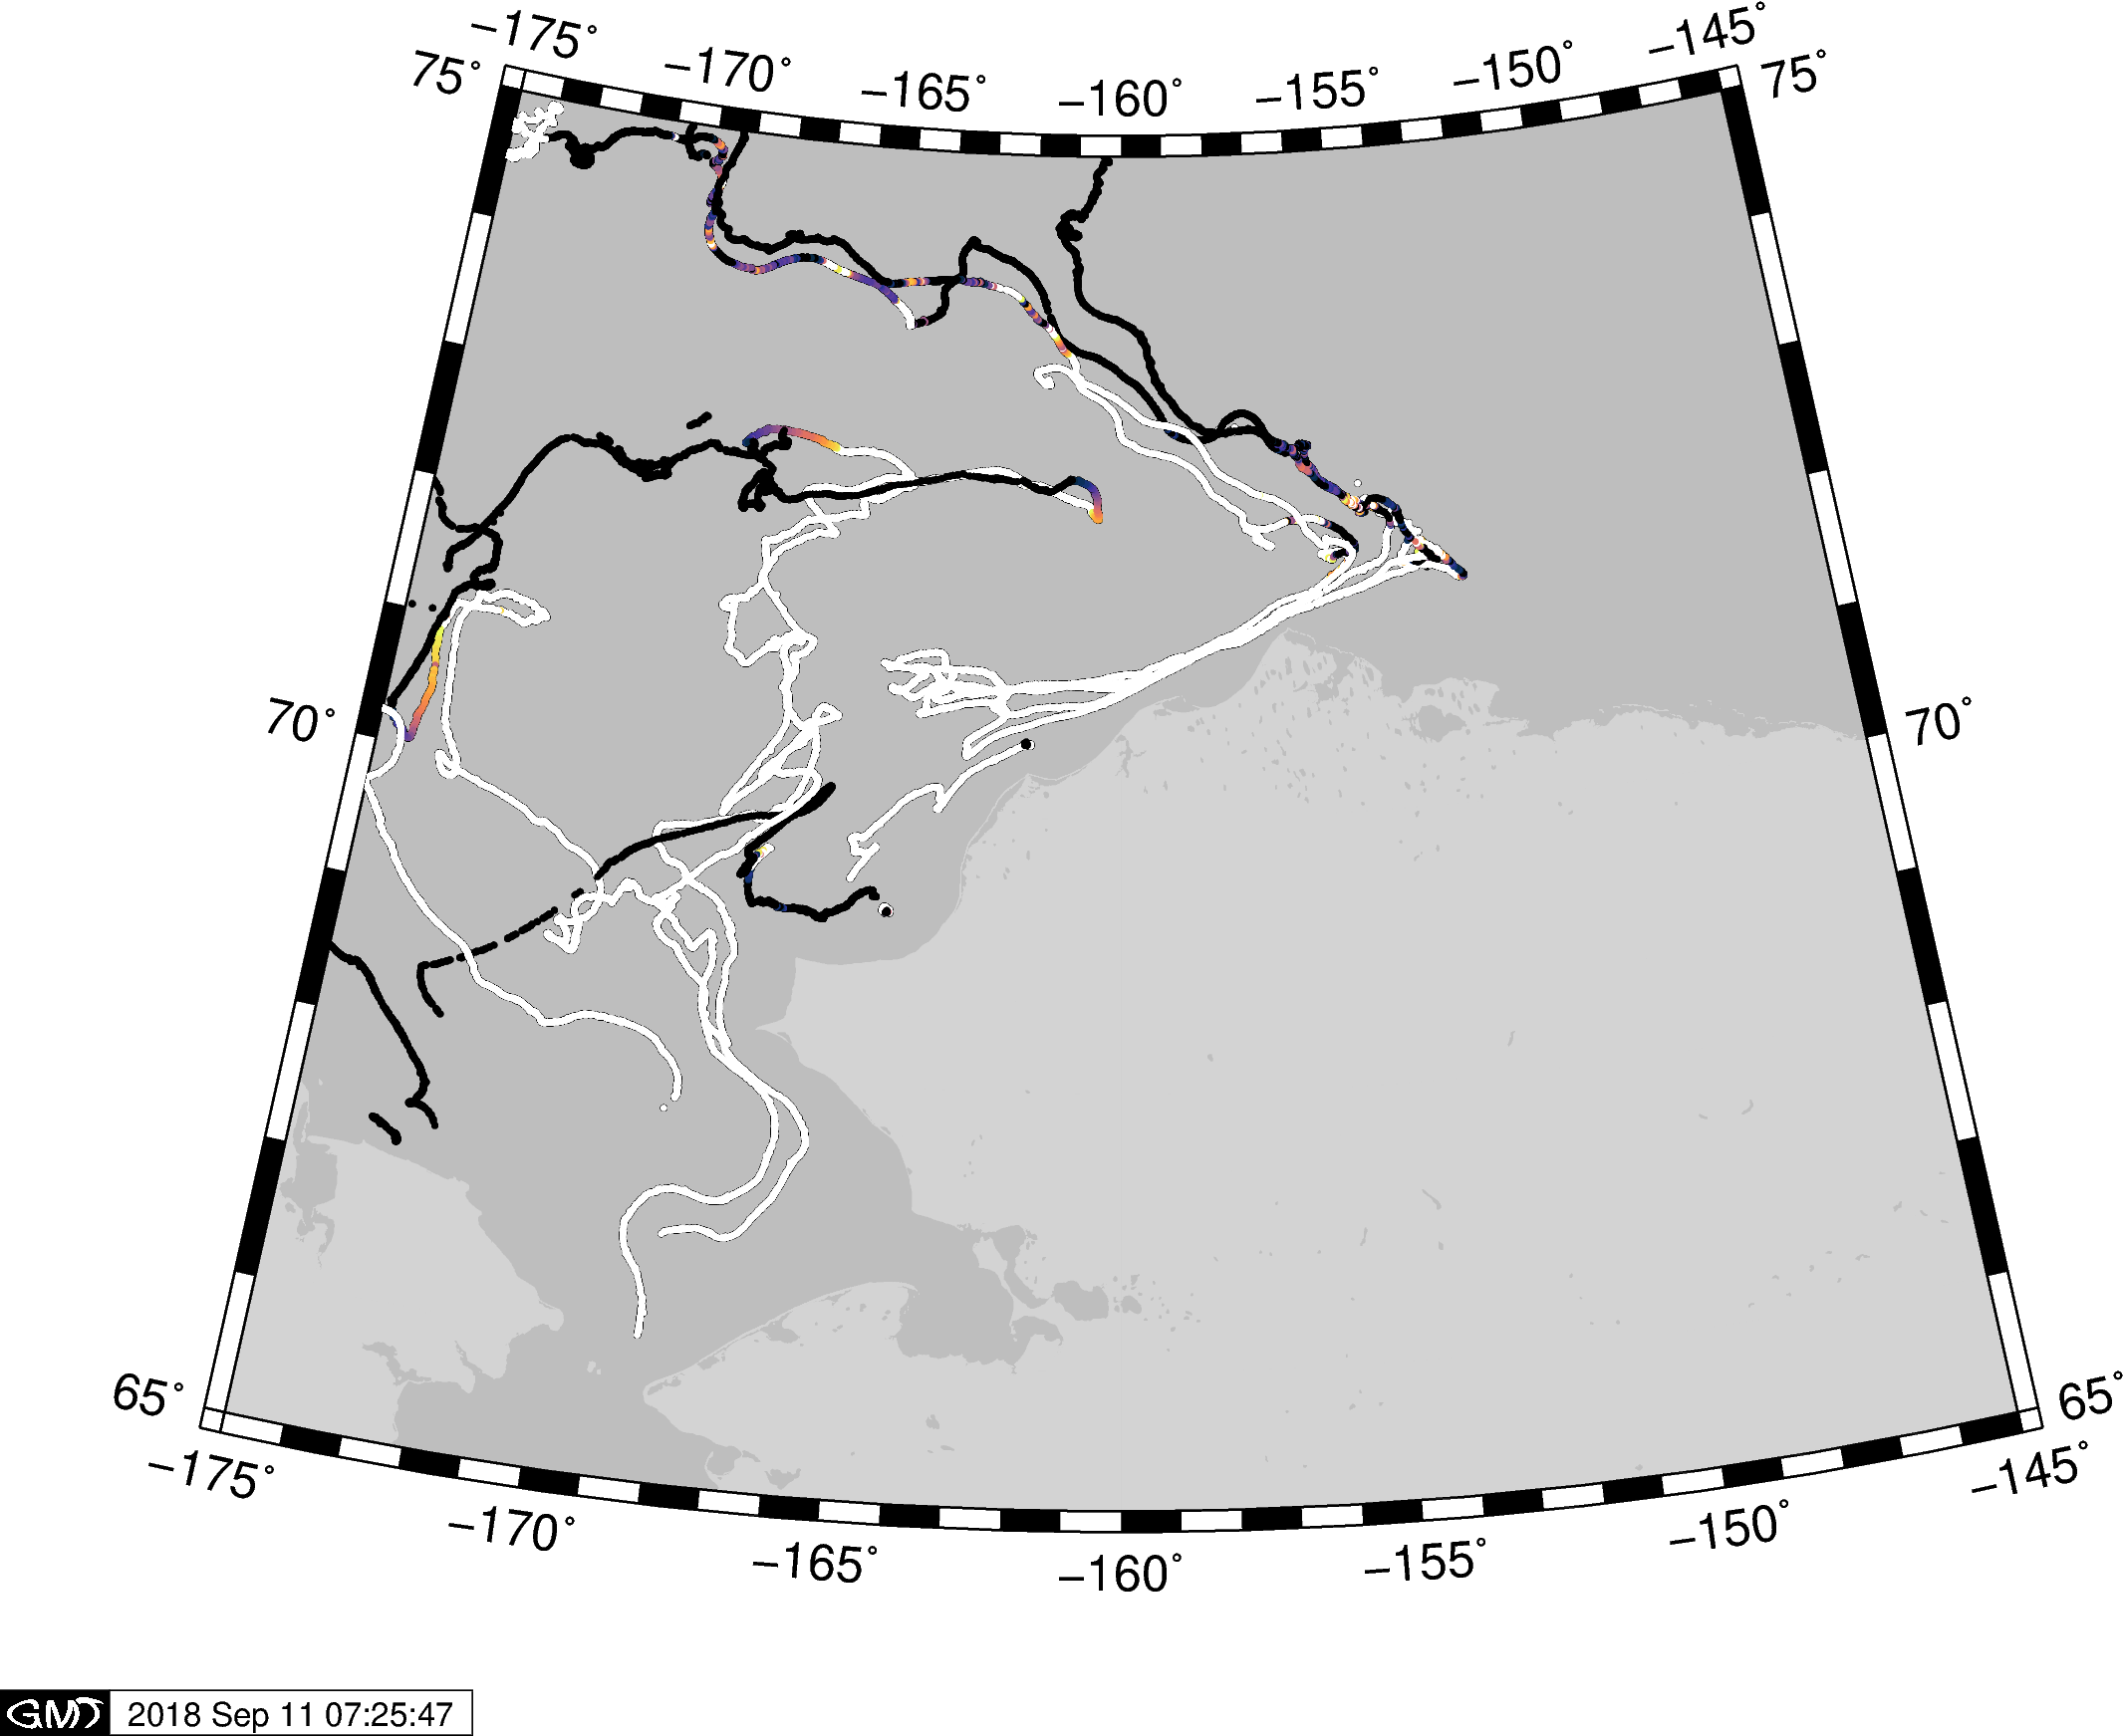

In [86]:
fig.show()

### Daily Plot using python-gmt

This creates an image for each day with a 7 day tail for the range of doy values specified

In [82]:
#choose temp boundaries
for dstep in range(180,365):

    fig1 = gmt.Figure()

    fig1.coast(region=[-175, -145, 65, 75], projection='B-160/60/55/60/6i', land='black', water='gray',
      frame=True,U=True)
    
    for drifterid,ddata in data.items():
        
        stopdate=datetime.datetime.strftime(datetime.datetime(2015,1,1)+datetime.timedelta(days=dstep),'%Y-%m-%d')
        startdate=datetime.datetime.strftime(datetime.datetime(2015,1,1)+datetime.timedelta(days=dstep)-datetime.timedelta(days=7),'%Y-%m-%d')
        
        dfmiss = ddata[startdate:stopdate].copy()

        dfnorm = dfmiss.apply(lambda x: (x - (-2)) / (14 - (2)))
        
        try:
            fig1.plot(x=-1*dfmiss.longitude, y=dfmiss.latitude, color=256*dfnorm.sst, cmap='thermal', style='c0.05c')
        except:
            pass
            
    fig1.savefig(stopdate + '.png')